In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('./datasets/train.csv')
print(df.head(5))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


### Read and Split Data

In [2]:
print("Label:\n", df.loc[0, 'Popularity'])
print("Content:\n",df.loc[0,'Page content'])

Label:
 -1
Content:
 <html><head><div class="article-info"> <span class="byline basic">Clara Moskowitz</span> for <a href="/publishers/space-com/">Space.com</a> <time datetime="Wed, 19 Jun 2013 15:04:30 +0000">2013-06-19 15:04:30 UTC</time> </div></head><body><h1 class="title">NASA's Grand Challenge: Stop Asteroids From Destroying Earth</h1><figure class="article-image"><img class="microcontent" data-fragment="lead-image" data-image="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg" data-micro="1" data-url="http://mashable.com/2013/06/19/nasa-grand-challenge-asteroid/" src="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg"/></figure><article data-channel="world"><section class="article-content"> <p>There may be killer asteroids headed for Earth, and NASA has decided to do something about it. The space agency announced a new "Grand Challenge" on June 18 to find all dangerous space rocks

In [3]:
X = df.loc[:, 'Page content'].to_numpy()
y = df.loc[:,'Popularity'].to_numpy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

print(X_train.shape)
print(y_train.shape)
print("Label:\n", y_train[0])
print("Content:\n", X_train[0])

(22114,)
(22114,)
Label:
 -1
Content:
 <html><head><div class="article-info"><span class="byline "><a href="/author/emily-banks/"><img alt="Default-m" class="author_image" src="http://i.amz.mshcdn.com/raEPzavg65Jzvjy-L4U699QBlmQ=/90x90/default-m.jpg"/></a><span class="author_name">By <a href="/author/emily-banks/">Emily Banks</a></span><time datetime="Fri, 01 Mar 2013 14:53:58 +0000">2013-03-01 14:53:58 UTC</time></span></div></head><body><h1 class="title">Mason Out at Groupon and More News You Need to Know</h1><figure class="article-image"></figure><article data-channel="business"><section class="article-content"> <div class="shift-to-hero"><div class="content-mash-video" data-autoplay="" data-embedurl="http://mashable.com/videos/embed?video=uGc7uydu&amp;player=offsite" data-labels='["Advertising", "Andrew Mason", "CEO", "Facebook", "Groupon", "adidas", "atlas", "college basketball", "first to know", "microsoft", "newsy", "twitter"]' data-playlist="http://content.jwplatform.com/manife

### Feature Engineering

In [4]:
import re
from bs4 import BeautifulSoup

def preprocessor(text):
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = r'(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)

    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub(r'[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

In [5]:
from collections import Counter
from string import punctuation

soup = BeautifulSoup(X[70], 'html.parser')
print(soup.prettify())

# Title
print("Title: ", soup.find("h1", {"class": "title"}).text)

# Channel
print("Data Channel: ", soup.find("article").get("data-channel"))

# Author
author_re = r'(By\s|^)(.*?)(?=\d{4}-\d{2}-\d{2}|$)'
if soup.head.find("span") == None:
    print("Author: None")
else:
    print("Author: ", re.search(author_re, soup.head.find("span").text).group(1))

# Related Topics
print("Topics: ", soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(","))

# Time
print("Time: ", re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5])

# Weekend
print("Weekend: ", int(soup.time.get("datetime")[:3] in ["Sat", "Sun"]))

# Word Count
text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
total = c_div + c_p
print("Total words: ", len(list(total.elements())))


section = soup.find("section", {"class": "article-content"})

# Video + Image count
img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
media_count = img_count + video_count
print("Media count: ", media_count)

# Appealing count
link_count = len(section.find_all("a"))
strong_count = len(section.find_all("strong"))
appealing_count = link_count + strong_count
print("Link count: ", appealing_count)


<html>
 <head>
  <div class="article-info">
   <a href="/publishers/businessnewsdaily/">
    BusinessNewsDaily
   </a>
   <time datetime="Mon, 20 Jan 2014 18:00:42 +0000">
    2014-01-20 18:00:42 UTC
   </time>
  </div>
 </head>
 <body>
  <h1 class="title">
   Senior Employees Are a Firm's Biggest Cybersecurity Weakness
  </h1>
  <figure class="article-image">
   <img alt="An Apple employee demonstrates the new iPad Mini in San Francisco on Oct. 22, 2013." class="microcontent" data-fragment="lead-image" data-image="http://i.amz.mshcdn.com/bROTa4dc55oQPOJWN72dq2rv6Lk=/950x534/2014%2F01%2F20%2Fc4%2FiPadMini.f3d59.jpg" data-micro="1" data-url="http://mashable.com/2014/01/20/cybersecurity-threat-survey/" src="http://i.amz.mshcdn.com/bROTa4dc55oQPOJWN72dq2rv6Lk=/950x534/2014%2F01%2F20%2Fc4%2FiPadMini.f3d59.jpg"/>
   <figcaption class="image-caption">
    An Apple employee demonstrates the new iPad Mini in San Francisco on Oct. 22, 2013.
   </figcaption>
   <div class="image-credit">
    Ima

In [6]:
def feature_selection_print(data):
    soup = BeautifulSoup(data, 'html.parser')

    # Title
    print("Title: ", soup.find("h1", {"class": "title"}).text)

    # Channel
    print("Data Channel: ", soup.find("article").get("data-channel"))

    # Author
    author_re = r'(?:By\s)?([a-zA-Z]+(\s[a-zA-Z]+)*)'
    if soup.head.find("span") == None:
        print("Author: None")
    else:
        # print(soup.head.find("span").text)
        print("Author: ", re.search(author_re, soup.head.find("span").text).group(1))

    # Related Topics
    print("Topics: ", soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(","))

    # Time
    print("Time: ", re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5])

    # Weekend
    print("Weekend: ", int(soup.time.get("datetime")[:3] in ["Sat", "Sun"]))

    # Word Count
    text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
    c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
    text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
    c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
    total = c_div + c_p
    print("Total words: ", len(list(total.elements())))


    section = soup.find("section", {"class": "article-content"})

    # Video + Image count
    img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
    video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
    media_count = img_count + video_count
    print("Media count: ", media_count)

    # Appealing count
    link_count = len(section.find_all("a"))
    strong_count = len(section.find_all("strong"))
    appealing_count = link_count + strong_count
    print("Link count: ", appealing_count)


for i in range(200, 205):
    print("Article ", i)
    feature_selection_print(X[i])

Article  200
Title:  California on Track to Enact Nation's First Statewide Plastic Bag Ban
Data Channel:  world
By Katie Sola2014-09-05 21:55:58 UTC
Author:  Katie Sola
Topics:  ['california', ' environmentalism', ' plastic', ' U.S.', ' World ']
Time:  21:55
Weekend:  0
Total words:  437
Media count:  0
Link count:  15
Article  201
Title:  9 Apps and Resources to Learn American Sign Language
Data Channel:  apps-software
By Yohana Desta2014-04-21 06:03:09 -0400
Author:  Yohana Desta
Topics:  ['Apps and Software', ' disabilities', ' education', ' Lifestyle', ' Sign Language', ' Social Good', ' Social Media', ' Work & Play ']
Time:  06:03
Weekend:  0
Total words:  515
Media count:  6
Link count:  18
Article  202
Title:  Dicycles: The Scooter Gets a Hip Upgrade
Data Channel:  tech
By Matt Petronzio2013-05-01 19:33:45 UTC
Author:  Matt Petronzio
Topics:  ['campaigns', ' Dev & Design', ' dicycle', ' Gadgets', ' Global Innovation Series', ' green', ' segway', ' Tech', ' Travel', ' Travel & Le

In [7]:
def feature_selection(data):
    feature_str = ""
    soup = BeautifulSoup(data, 'html.parser')

    # Title
    feature_str += soup.find("h1", {"class": "title"}).text + " "

    # Channel
    feature_str += soup.find("article").get("data-channel") + " "

    # Author
    author_re = r'(?:By\s)?([a-zA-Z]+(\s[a-zA-Z]+)*)'
    if soup.head.find("span") == None:
        feature_str += " "
    else:
        feature_str += re.search(author_re, soup.head.find("span").text).group(1) + " "

    # Related Topics
    feature_str += soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").replace(",", "")

    # Time
    if soup.time.text == None or soup.time.text == "":
        feature_str += "0"
    else:
        hour = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[0])
        minute = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[1])
        feature_str += str(hour * 60 + minute) + " "

    # Weekend
    if soup.time.text == None or soup.time.text == "":
        feature_str += "0 "
    else:
        feature_str += "1 " if soup.time.get("datetime")[:3] in ["Sat", "Sun"] else "0 "

    # Word Count
    text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
    c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
    text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
    c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
    total = c_div + c_p
    feature_str += str(len(list(total.elements()))) + " "


    section = soup.find("section", {"class": "article-content"})

    # Video + Image count
    img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
    video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
    media_count = img_count + video_count
    feature_str += str(media_count) + " "

    # Appealing count
    link_count = len(section.find_all("a"))
    strong_count = len(section.find_all("strong"))
    appealing_count = link_count + strong_count
    feature_str += str(appealing_count)

    feature_str = re.sub(r'[\W]+', ' ', feature_str.lower())
    return feature_str

print(feature_selection(X[0]))

nasa s grand challenge stop asteroids from destroying earth world clara moskowitz asteroid asteroids challenge earth space u s world 904 0 543 0 18


In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z0-9]+', w)]

print(tokenizer_stem_nostop(feature_selection(X[0])))

['nasa', 'grand', 'challeng', 'stop', 'asteroid', 'destroy', 'earth', 'world', 'clara', 'moskowitz', 'asteroid', 'asteroid', 'challeng', 'earth', 'space', 'u', 'world', '904', '0', '543', '0', '18']


In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2),
                        preprocessor=preprocessor,
                        tokenizer=tokenizer_stem_nostop)

tfidf.fit(X_train)

top = 10
# get idf score of vocabularies
idf = tfidf.idf_
print('[vocabularies with smallest idf scores]')
sorted_idx = idf.argsort()

for i in range(top):
    # When sklearn version <= 0.24.x, should use get_feature_names()
    # When sklearn version >= 1.0.x, should use get_feature_names_out()
    print('%s: %.2f' %(tfidf.get_feature_names_out()[sorted_idx[-(i+1)]], idf[sorted_idx[-(i+1)]]))


# doc_tfidf = tfidf.transform(X_train).toarray()
# tfidf_sum = np.sum(doc_tfidf, axis=0)
# print("\n[vocabularies with highest tf-idf scores]")
# for tok, v in zip(tfidf.inverse_transform(np.ones((1, tfidf_sum.shape[0])))[0][tfidf_sum.argsort()[::-1]][:top], \
#                         np.sort(tfidf_sum)[::-1][:top]):
#     print('{}: {}'.format(tok, v))

[vocabularies with smallest idf scores]
zürich topic: 10.31
giver stay: 10.31
givewel overhead: 10.31
givewel givewel: 10.31
givewel decemb: 10.31
givewel: 10.31
giveustheserum monday: 10.31
giveustheserum: 10.31
giveusschmidt annalis: 10.31
giveusschmidt: 10.31


### Model Training

In [11]:
import math

def random_mini_batches(X, Y, mini_batch_size = 64):
    m = X.shape[0]  # number of training examples
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation]
    shuffled_Y = Y[permutation]
    
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


### TF-IDF + SGD

In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

clf = SGDClassifier(loss='log_loss', alpha=0.01, max_iter=100, tol=1e-3)

In [14]:
train_auc, val_auc = [], []
iters = 1
batch_size = 512
classes = np.array([-1, 1])

# train_tfidf = tfidf.transform(X_train).toarray()
# valid_tfidf = tfidf.transform(X_valid).toarray()

for i in range(iters):
    print(f"epoch: {i+1}/{iters}")
    train_batches = random_mini_batches(X_train, y_train, batch_size)
    valid_batches = random_mini_batches(X_valid, y_valid, int(batch_size * 0.2))
    idx = 0
    for train_batch in train_batches:
        x_batch, y_batch = train_batch
        x_batch = tfidf.transform(x_batch)
        clf.partial_fit(x_batch, y_batch, classes=classes)
        train_score = roc_auc_score(y_batch, clf.predict_proba(x_batch)[:,1])
        train_auc.append(train_score)
        print(f'[{(idx+1)*batch_size}/{X_train.shape[0]}]')
        print(f'Train score: {train_score}')
        
        x_batch, y_batch = valid_batches[idx]
        valid_score = roc_auc_score(y_batch, clf.predict_proba(tfidf.transform(x_batch))[:,1])
        val_auc.append(valid_score)
        print(f'Valid score: {valid_score}')
        idx+=1

epoch: 1/1
[512/22114]
Train score: 0.8514658079875472
Valid score: 0.5524691358024691
[1024/22114]
Train score: 0.8645699418426691
Valid score: 0.5059961315280463
[1536/22114]
Train score: 0.827267156862745
Valid score: 0.5535714285714286
[2048/22114]
Train score: 0.835799471650862
Valid score: 0.4533699059561129
[2560/22114]
Train score: 0.849076354679803
Valid score: 0.49862041781631855
[3072/22114]
Train score: 0.8022748091603054
Valid score: 0.5415204678362573
[3584/22114]
Train score: 0.791774134119381
Valid score: 0.5601851851851852
[4096/22114]
Train score: 0.7607429488649392
Valid score: 0.5306122448979592
[4608/22114]
Train score: 0.7940696201565767
Valid score: 0.5783699059561128
[5120/22114]
Train score: 0.7814350241103583
Valid score: 0.5136485966935793
[5632/22114]
Train score: 0.7690759658959982
Valid score: 0.6499802916830902
[6144/22114]
Train score: 0.7600274725274726
Valid score: 0.6052018633540373
[6656/22114]
Train score: 0.7818914956011731
Valid score: 0.699230769

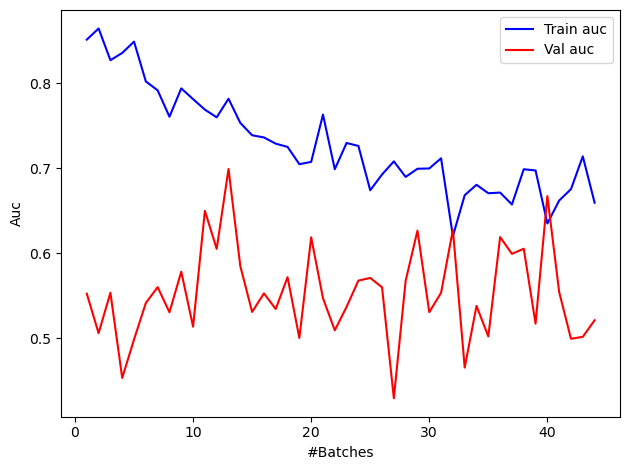

In [15]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.show()

In [16]:
valid_score = roc_auc_score(y_valid, clf.predict_proba(tfidf.transform(X_valid))[:,1])
print(f'Valid score: {valid_score}')

Valid score: 0.553351973291625


In [17]:
print(clf.predict_proba(tfidf.transform(X_train[:10]))[:10,1])

[0.4851678  0.48914752 0.48967935 0.48815584 0.48787061 0.49141736
 0.49600966 0.48665617 0.48874472 0.49147739]


### Feature Hashing + SGD

In [38]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

# loss='log' gives logistic regression
# sklearn version > 1.0 should use log_loss
clf = SGDClassifier(loss='log_loss', max_iter=100, tol=1e-3)
hashvec = HashingVectorizer(n_features=2**20,
                            preprocessor=feature_selection, tokenizer=tokenizer_stem_nostop)

In [64]:
batch_size = 512
classes = np.array([-1, 1])
train_auc, val_auc = [], []
# we use one batch for training and another for validation in each iteration
iters = 5

for i in range(iters):
    print(f"epoch: {i+1}/{iters}")
    train_batches = random_mini_batches(X_train, y_train, batch_size)
    valid_batches = random_mini_batches(X_valid, y_valid, int(batch_size * 0.2))
    idx = 0
    for train_batch in train_batches:
        x_batch, y_batch = train_batch
        x_batch = hashvec.transform(x_batch)
        clf.partial_fit(x_batch, y_batch, classes=classes)
        train_score = roc_auc_score(y_batch, clf.predict_proba(x_batch)[:,1])
        train_auc.append(train_score)
        print(f'[{(idx+1)*batch_size}/{X_train.shape[0]}]')
        print(f'Train score: {train_score}')
        
        x_batch, y_batch = valid_batches[idx]
        valid_score = roc_auc_score(y_batch, clf.predict_proba(hashvec.transform(x_batch))[:,1])
        val_auc.append(valid_score)
        print(f'Valid score: {valid_score}')
        idx+=1

epoch: 1/5
[512/22114]
Train score: 0.6963129276637342
Valid score: 0.5964574509048903
[1024/22114]
Train score: 0.7416971916971917
Valid score: 0.6081986598344501
[1536/22114]
Train score: 0.7406624059343725
Valid score: 0.654938024790084
[2048/22114]
Train score: 0.6894331273365377
Valid score: 0.5121856866537717
[2560/22114]
Train score: 0.7046463721675441
Valid score: 0.5240662302656912
[3072/22114]
Train score: 0.728860294117647
Valid score: 0.5315280464216635
[3584/22114]
Train score: 0.7329802981976894
Valid score: 0.5158179012345679
[4096/22114]
Train score: 0.7373004354136431
Valid score: 0.5551710880430603
[4608/22114]
Train score: 0.7137814047313406
Valid score: 0.5238470634607805
[5120/22114]
Train score: 0.720310901400278
Valid score: 0.5168495297805643
[5632/22114]
Train score: 0.7472017346954356
Valid score: 0.592079969242599
[6144/22114]
Train score: 0.7229502688172043
Valid score: 0.5849428458809618
[6656/22114]
Train score: 0.6859063478725843
Valid score: 0.6339181286

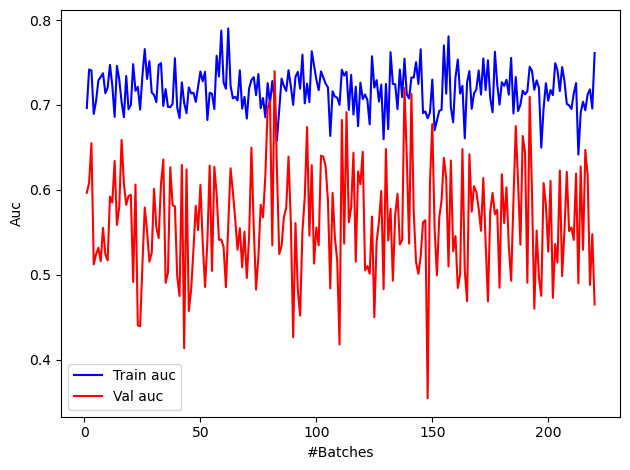

In [65]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.show()

In [66]:
train_score = roc_auc_score(y_train, clf.predict_proba(hashvec.transform(X_train))[:,1])
valid_score = roc_auc_score(y_valid, clf.predict_proba(hashvec.transform(X_valid))[:,1])
print(f'Train score: {train_score}')
print(f'Valid score: {valid_score}')

print("Check predict result:\n")
print(clf.predict_proba(hashvec.transform(X_train[:10]))[:10,1])

Train score: 0.7088427281097691
Valid score: 0.5625592804065301
Check predict result:

[0.34489878 0.46385385 0.49846325 0.42563965 0.39860277 0.54477312
 0.58066547 0.40774082 0.51370481 0.64185883]


### Feature Hashing + XGBoost

In [52]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

hashvec = HashingVectorizer(n_features=2**20,
                            preprocessor=feature_selection, tokenizer=tokenizer_stem_nostop)

xgboost = xgb.XGBClassifier(learning_rate=0.01, reg_lambda=1)

In [53]:
batch_size = 1024
train_auc, val_auc = [], []
iters = 3

for i in range(iters):
    print(f"epoch: {i+1}/{iters}")
    train_batches = random_mini_batches(X_train, y_train, batch_size)
    valid_batches = random_mini_batches(X_valid, y_valid, int(batch_size * 0.2))
    idx = 0
    for train_batch in train_batches:
        x_batch, y_batch = train_batch
        x_batch = hashvec.transform(x_batch)
        y_batch = LabelEncoder().fit_transform(y_batch)
        xgboost.fit(x_batch, y_batch)
        train_score = roc_auc_score(y_batch, xgboost.predict_proba(x_batch)[:,1])
        train_auc.append(train_score)
        print(f'[{(idx+1)*batch_size}/{X_train.shape[0]}]')
        print(f'Train score: {train_score}')
        
        x_batch, y_batch = valid_batches[idx]
        y_batch = LabelEncoder().fit_transform(y_batch)
        valid_score = roc_auc_score(y_batch, xgboost.predict_proba(hashvec.transform(x_batch))[:,1])
        val_auc.append(valid_score)
        print(f'Valid score: {valid_score}')
        idx+=1

epoch: 1/3
[1024/22114]
Train score: 0.8307658853689801
Valid score: 0.4558752300687785
[2048/22114]
Train score: 0.8512302586404212
Valid score: 0.537085137085137
[3072/22114]
Train score: 0.8430456147847452
Valid score: 0.5294543698696282
[4096/22114]
Train score: 0.8321921083334928
Valid score: 0.5320069204152249
[5120/22114]
Train score: 0.818851451433109
Valid score: 0.508423180592992
[6144/22114]
Train score: 0.8116209352504248
Valid score: 0.4951160541586073
[7168/22114]
Train score: 0.8540904495775077
Valid score: 0.4631211180124224
[8192/22114]
Train score: 0.8016242007825173
Valid score: 0.5915120638277419
[9216/22114]
Train score: 0.8319407085217192
Valid score: 0.4085137085137085
[10240/22114]
Train score: 0.8340634787258421
Valid score: 0.5708173076923077
[11264/22114]
Train score: 0.8401682560058683
Valid score: 0.5232602845059593
[12288/22114]
Train score: 0.8157523164048786
Valid score: 0.6148472877926582
[13312/22114]
Train score: 0.8344323854009251
Valid score: 0.5376

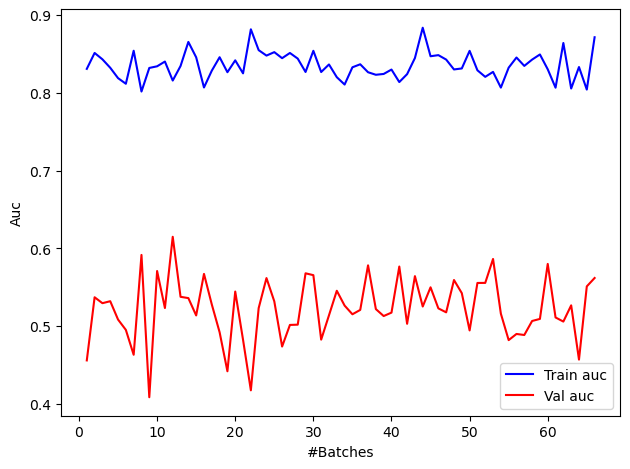

In [54]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.show()

In [57]:
train_score = roc_auc_score(LabelEncoder().fit_transform(y_train), xgboost.predict_proba(hashvec.transform(X_train))[:,1])
valid_score = roc_auc_score(LabelEncoder().fit_transform(y_valid), xgboost.predict_proba(hashvec.transform(X_valid))[:,1])
print(f'Train score: {train_score}')
print(f'Valid score: {valid_score}')

print("Check predict result:\n")
print(xgboost.predict_proba(hashvec.transform(X_train[:10]))[:10,1])

Train score: 0.534898078666052
Valid score: 0.524597115700697
Check predict result:

[0.45446816 0.49336192 0.5084322  0.48132437 0.38319325 0.52109694
 0.42833763 0.464129   0.46150956 0.5519009 ]


### Prediction

In [61]:
df = pd.read_csv('./datasets/test.csv')
print("Content:\n",df.loc[0])

Id = df.loc[:, 'Id'].to_numpy()
X_test = df.loc[:, 'Page content'].to_numpy()
print(X_test.shape)
print("\nId:\n", Id[0])
print("Content:\n", X_test[0])

Content:
 Id                                                          27643
Page content    <html><head><div class="article-info"><span cl...
Name: 0, dtype: object
(11847,)

Id:
 27643
Content:
 <html><head><div class="article-info"><span class="byline "><a href="/author/sam-laird/"><img alt="2016%2f09%2f15%2f63%2fhttpsd2mhye01h4nj2n.cloudfront.netmediazgkymde1lza2.9814b" class="author_image" src="http://i.amz.mshcdn.com/-qaMPB8aiQeIaoBhqlU0OLjA07A=/90x90/2016%2F09%2F15%2F63%2Fhttpsd2mhye01h4nj2n.cloudfront.netmediaZgkyMDE1LzA2.9814b.jpg"/></a><span class="author_name">By <a href="/author/sam-laird/">Sam Laird</a></span><time datetime="Mon, 09 Sep 2013 19:47:02 +0000">2013-09-09 19:47:02 UTC</time></span></div></head><body><h1 class="title">Soccer Star Gets Twitter Death Threats After Tackling One Direction Member</h1><figure class="article-image"></figure><article data-channel="entertainment"><section class="article-content"> <div class="shift-to-hero"> <p><iframe allowfullscreen="" 

In [67]:
y_pred = np.around(clf.predict_proba(hashvec.transform(X_test))[:,1], decimals=1)
print(y_pred.shape)
print(y_pred[0])

(11847,)
0.4


In [68]:
output_data = {'Id': Id, 'Popularity': y_pred}
output_dataframe = pd.DataFrame(output_data)
print(output_dataframe)

output_dataframe.to_csv("./datasets/y_pred.csv", index=None)

          Id  Popularity
0      27643         0.4
1      27644         0.7
2      27645         0.4
3      27646         0.4
4      27647         0.5
...      ...         ...
11842  39485         0.5
11843  39486         0.5
11844  39487         0.5
11845  39488         0.5
11846  39489         0.5

[11847 rows x 2 columns]
